<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Question%20Classification%20TREC%20Dataset/TREC_Question_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [3]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

#bin/bash
!mkdir ~/kaggle
!cp kaggle.json ~/kaggle
!chmod 600 ~/kaggle/kaggle.json
!kaggle datasets download thedevastator/the-trec-question-classification-dataset-a-longi
!unzip the-trec-question-classification-dataset-a-longi.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/thedevastator/the-trec-question-classification-dataset-a-longi
License(s): CC0-1.0
  0% 0.00/123k [00:00<?, ?B/s]
100% 123k/123k [00:00<00:00, 223MB/s]
Archive:  the-trec-question-classification-dataset-a-longi.zip
  inflating: test.csv                
  inflating: train.csv               


# Import Libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import requests
import zipfile

# Loading Dataset

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
# Train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452 entries, 0 to 5451
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label-coarse  5452 non-null   int64 
 1   label-fine    5452 non-null   int64 
 2   text          5452 non-null   object
dtypes: int64(2), object(1)
memory usage: 127.9+ KB


In [7]:
# Test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label-coarse  500 non-null    int64 
 1   label-fine    500 non-null    int64 
 2   text          500 non-null    object
dtypes: int64(2), object(1)
memory usage: 11.8+ KB


## Visualize Distribution

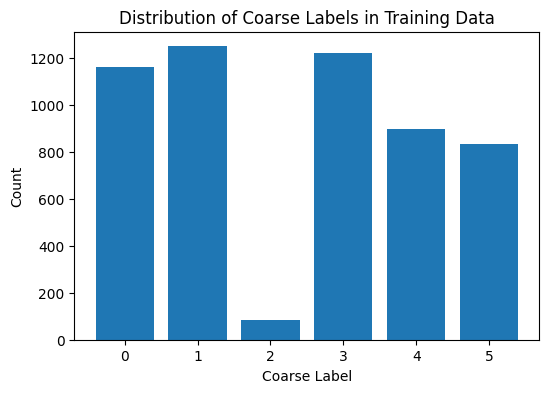

In [31]:
# Train Data
plt.figure(figsize=(6, 4))
value_counts = train['label-coarse'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Coarse Label')
plt.ylabel('Count')
plt.title('Distribution of Coarse Labels in Training Data')
plt.show()

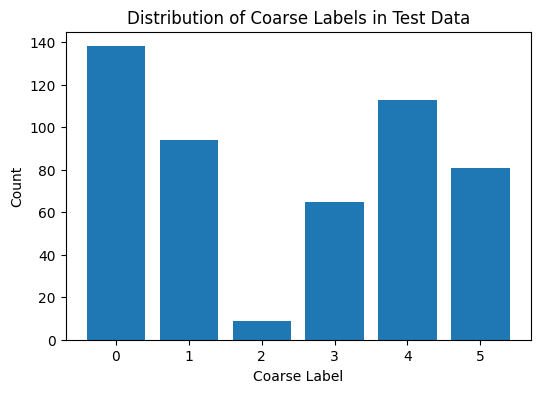

In [32]:
# Test Data
plt.figure(figsize=(6, 4))
value_counts = test['label-coarse'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Coarse Label')
plt.ylabel('Count')
plt.title('Distribution of Coarse Labels in Test Data')
plt.show()

## Optimal `sequence_length_tokens`

In [42]:
# All sentences lengths
sequence_lengths = [len(text.split()) for text in train['text']]

# Statistical Analysis
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
max_length = np.max(sequence_lengths)
min_length = np.min(sequence_lengths)

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")

# Percentiles
percentiles = np.percentile(sequence_lengths, [90, 95, 99])
print(f"90th Percentile: {percentiles[0]}")
print(f"95th Percentile (Median): {percentiles[1]}")
print(f"99th Percentile: {percentiles[2]}")

Mean Length: 10.204695524578137
Median Length: 10.0
Max Length: 37
Min Length: 3
90th Percentile: 15.0
95th Percentile (Median): 17.0
99th Percentile: 22.0


## `sequence_lengths` Distribution

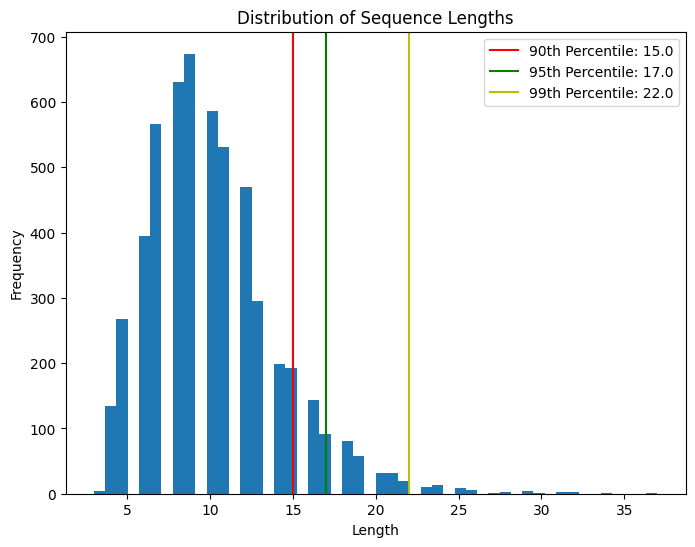

In [50]:
plt.figure(figsize=(8, 6))
plt.hist(sequence_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.axvline(x=percentiles[0], color='r', label=f'90th Percentile: {percentiles[0]}')
plt.axvline(x=percentiles[1], color='g', label=f'95th Percentile: {percentiles[1]}')
plt.axvline(x=percentiles[2], color='y', label=f'99th Percentile: {percentiles[2]}')
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Split X/y

In [57]:
X_train = train['text'].values
Y_train = train['label-coarse'].values

print(f"X Train Shape: {X_train.shape}")
print(f"Y Train Shape: {Y_train.shape}")

X_test = test['text'].values
Y_test = test['label-coarse'].values

print(f"X Test Shape: {X_test.shape}")
print(f"Y Test Shape: {Y_test.shape}")

X Train Shape: (5452,)
Y Train Shape: (5452,)
X Test Shape: (500,)
Y Test Shape: (500,)


# TextVectorization

In [109]:
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 20_000
MAX_SEQ_LENGTH = 18

vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=MAX_SEQ_LENGTH,
)


In [110]:
# Adapting Vectorizer
vectorizer.adapt(X_train)

# Inspect vectorizer
vocabulary = vectorizer.get_vocabulary()
print(f"Vocabulary size: {len(vocabulary)}")
print("Top 10 words in vocabulary:", vocabulary[:10])

Vocabulary size: 8604
Top 10 words in vocabulary: ['', '[UNK]', np.str_('the'), np.str_('what'), np.str_('is'), np.str_('of'), np.str_('in'), np.str_('a'), np.str_('how'), np.str_('s')]


# Add GloVe to Project

In [111]:
EMBEDDING_DIM_GLOVE = 100
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP_FILE = "glove.6B.zip"
GLOVE_FILE = f"glove.6B.{EMBEDDING_DIM_GLOVE}d.txt"

if not os.path.exists(GLOVE_FILE):
    response=requests.get(GLOVE_URL)
    with open(GLOVE_ZIP_FILE, "wb") as z:
        z.write(response.content)
    with zipfile.ZipFile(GLOVE_ZIP_FILE, "r") as z:
        z.extractall()
    print("GloVe Downloaed and Extraction Complete.")

print("Loading GloVe Vectors into Memory...")
glove_embeddings = {}
with open(GLOVE_FILE, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

# Create the embedding matrix
print("Creating GloVe embedding matrix...")
word_to_idx = {word: i for i, word in enumerate(vocabulary)}
embedding_matrix_glove = np.zeros((VOCAB_SIZE, EMBEDDING_DIM_GLOVE))
num_tokens_found_glove = 0
for word, i in word_to_idx.items():
    if i < VOCAB_SIZE:
        vector = glove_embeddings.get(word)
        if vector is not None:
            embedding_matrix_glove[i] = vector
            num_tokens_found_glove += 1
print(f"Found {num_tokens_found_glove} tokens in GloVe embeddings.")

Loading GloVe Vectors into Memory...
Creating GloVe embedding matrix...
Found 8161 tokens in GloVe embeddings.


# Create Tensorflow Dataset

In [112]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# This function will apply the adapted vectorizer to the text data.
def preprocess_text(text, label):
    text = vectorizer(text)
    return text, label

# Apply the preprocessing to the datasets
# We also batch and prefetch for performance.
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_dataset = train_dataset.map(
    preprocess_text, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.map(
    preprocess_text, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Model Definition

In [125]:
# Define hyperparameters
GRU_UNITS_1 = 64
GRU_UNITS_2 = 32
NUM_CLASSES = len(np.unique(Y_train))

print(f"\n[INFO] Building the model with Vocab Size: {VOCAB_SIZE} and Num Classes: {NUM_CLASSES}\n\n")

# Model (Functional API)
def build_model():
    inputs = tf.keras.Input(shape=(MAX_SEQ_LENGTH, ), dtype=tf.int32)
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM_GLOVE,
        weights=[embedding_matrix_glove],
        mask_zero=True,
        trainable=False,
        name='embedding'
    )(inputs)
    recurrent_layer_1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            units=GRU_UNITS_1,
            return_sequences=True,
            name='gru'
        )
    )(embedding_layer)
    dropout_layer_1 = tf.keras.layers.Dropout(0.5)(recurrent_layer_1)
    recurrent_layer_2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            units=GRU_UNITS_2,
            name='gru'
        )
    )(dropout_layer_1)
    dropout_layer_2 = tf.keras.layers.Dropout(0.5)(recurrent_layer_2)
    output = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(dropout_layer_2)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="Question_Clf")
    return model

model = build_model()
model.summary()


[INFO] Building the model with Vocab Size: 20000 and Num Classes: 6




Model: "Question_Clf"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 18, 100)   │  2,000,000 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, 18)        │          0 │ input_layer_18[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 18, 128)   │     63,744 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 18, 128)   │          0 │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 64)        │     31,104 │ dropout_9[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ bidirectional_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 6)         │        390 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,095,238 (7.99 MB)

 Trainable params: 95,238 (372.02 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

# Preparing Model for Training

In [126]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [127]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

In [128]:
EPOCHS = 30
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.4117 - loss: 1.4352 - val_accuracy: 0.7740 - val_loss: 0.7199 - learning_rate: 0.0010
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.7227 - loss: 0.7834 - val_accuracy: 0.8420 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.7867 - loss: 0.6126 - val_accuracy: 0.8720 - val_loss: 0.4180 - learning_rate: 0.0010
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8222 - loss: 0.5160 - val_accuracy: 0.8760 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.8411 - loss: 0.4579 - val_accuracy: 0.8800 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8653 - loss: 0.3962 - val_accuracy: 0.9160 - val_loss: 0.2963 - learning_rate: 0.0010
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8798 - l

# Evaluation

In [129]:
final_loss, final_acc = model.evaluate(test_dataset)
print(f"Final Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_acc*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9202 - loss: 0.2526
Final Test Loss: 0.2579
Final Test Accuracy: 91.60%


# Inference

In [130]:
# Define some new questions to test the model
new_questions = [
    "Who was the first person on the moon?",
    "How tall is Mount Everest?",
    "What is the capital of France?",
    "Describe the process of photosynthesis."
]

# The model can predict directly on raw text if we include the vectorizer layer in it.
# Let's build a new model for inference that includes the vectorizer.
inference_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorizer, # The first layer is our adapted vectorizer
    model # The second "layer" is our entire trained model
])

# Convert the list of questions to a TensorFlow Dataset
new_questions_dataset = tf.data.Dataset.from_tensor_slices(new_questions).batch(1)


# Get predictions
predicted_probabilities = inference_model.predict(new_questions_dataset)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

class_names = ["Abbreviation", "Entity", "Description", "Human", "Location", "Numeric"]

print("\n--- Prediction Results ---")
for i, question in enumerate(new_questions):
    predicted_class_name = class_names[predicted_classes[i]]
    print(f"Question: '{question}'")
    print(f"Predicted Class: {predicted_class_name} (ID: {predicted_classes[i]})\n")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

--- Prediction Results ---
Question: 'Who was the first person on the moon?'
Predicted Class: Human (ID: 3)

Question: 'How tall is Mount Everest?'
Predicted Class: Location (ID: 4)

Question: 'What is the capital of France?'
Predicted Class: Numeric (ID: 5)

Question: 'Describe the process of photosynthesis.'
Predicted Class: Abbreviation (ID: 0)



# Fine Tuning `Embedding` Layer

In [131]:
# Load the best model from the initial training
best_model = tf.keras.models.load_model('model.keras')
# Unfreeze the embedding layer
best_model.get_layer('embedding').trainable = True

# Re-compile with a very low learning rate
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nStarting Fine-Tuning Phase")
best_model.summary()

from tensorflow.keras.callbacks import EarlyStopping

history_finetune = best_model.fit(
    train_dataset,
    epochs=10, # Allow a few more epochs
    validation_data=test_dataset, # Use the test_dataset for validation
    callbacks=[EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True)]
)


--- Starting Fine-Tuning Phase ---


Model: "Question_Clf"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 18, 100)   │  2,000,000 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, 18)        │          0 │ input_layer_18[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 18, 128)   │     63,744 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 18, 128)   │          0 │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 64)        │     31,104 │ dropout_9[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ bidirectional_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 6)         │        390 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,095,238 (7.99 MB)

 Trainable params: 2,095,238 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.9433 - loss: 0.1769 - val_accuracy: 0.9120 - val_loss: 0.2670
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9479 - loss: 0.1675 - val_accuracy: 0.9100 - val_loss: 0.2709
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9510 - loss: 0.1637 - val_accuracy: 0.9100 - val_loss: 0.2725
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9478 - loss: 0.1601 - val_accuracy: 0.9100 - val_loss: 0.2718
